# Lecture 07

Examples of examining systems of nonlinear equations and looking at linearized properties

In [1]:
import numpy as np

import sympy
from sympy import simplify, Function
from sympy import symbols, pprint
from sympy import sin, cos, asin, acos, pi, Abs
from sympy import Matrix, diff
from sympy import lambdify

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
plt.ion()


# Simulating a pendulum

In this notebook we will learn how to simulate a pendulum

In [2]:
import numpy as np
from scipy.integrate import solve_ivp

# import matplotlib as mpl
# mpl.use('Qt5Agg')

import matplotlib.pyplot as plt
plt.ion()


import warnings
warnings.filterwarnings('ignore')

Let's define a helper function to convert between rad->deg

In [3]:
def deg2rad(deg):
    return deg*np.pi/180

## Define the equations of motions


In [4]:
gravity = 9.8

# General inverted pendulum simulator
def pendulum(t, state, l):
    theta, omega = state
    dydt = [omega, -(gravity/l)*(np.sin(theta))]
    return dydt

## Define the initial conditions


In [5]:
# System constants
L = 1 
gravity = 9.8

# Initial condition
theta = deg2rad(20)
dtheta_dt = .1

dt = 0.001
time = np.linspace(0,10,int(10/dt))

Solve dynamics for the initial conditions and plot

Text(0.5, 0, 'time')

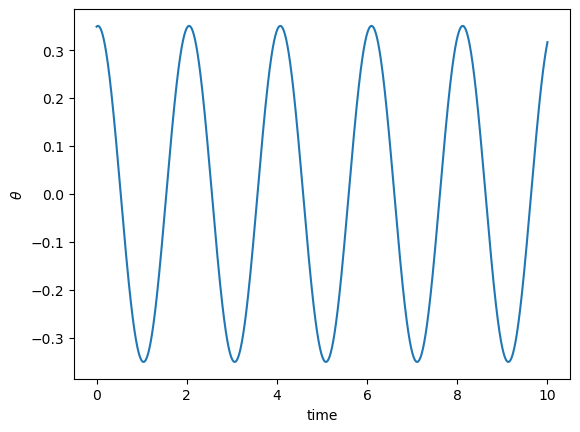

In [6]:
sol = solve_ivp(lambda t, y: pendulum(t, y, L), 
                [0,10], [theta, dtheta_dt], 
                t_eval = time, 
                rtol=1e-8, atol = 1e-8)
plt.figure(1)
plt.clf()
plt.plot(sol.t, sol.y[0,:])
plt.ylabel('$\\theta$')
plt.xlabel('time')

## Plot the phase space and a solution in phase-space

(-9.42477796076938, 9.42477796076938, -9.42477796076938, 9.42477796076938)

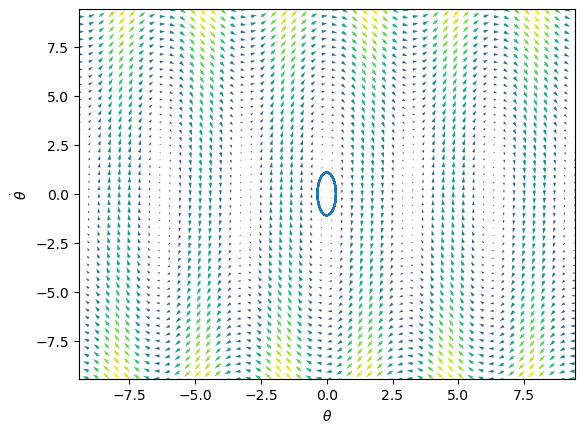

In [7]:
numpoints = 50
rng = 3*np.pi

[x1_vf, x2_vf] = np.meshgrid(np.linspace(-rng,rng,numpoints), 
                             np.linspace(-rng,rng,numpoints)) 

dynamics = pendulum(0, [x1_vf, x2_vf], L)
norm = dynamics[0]**2 + dynamics[1]**2

plt.figure(2)
plt.clf()
plt.quiver(x1_vf, x2_vf, dynamics[0], dynamics[1], norm)

plt.plot(sol.y[0,:], sol.y[1,:])

plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot{\theta}$')
plt.axis([-rng, rng, -rng, rng])


## Plot a bunch of solutions

(-10.0, 10.0, -7.5, 7.5)

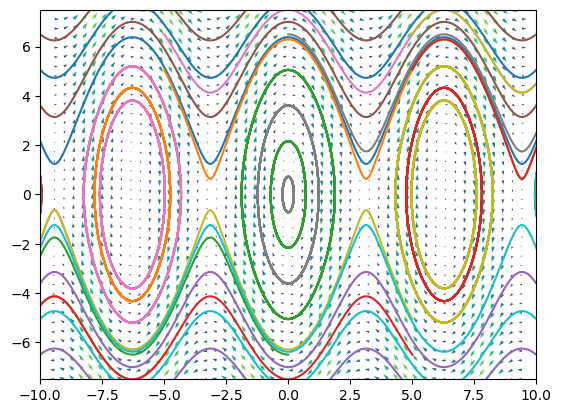

In [8]:
theta = np.linspace(-10, 10, 5)
dtheta_dt = np.linspace(-6.5, 6.5, 10)
[theta_start, dtheta_start] = np.meshgrid(theta, 
                                          dtheta_dt) 

#### Plot vector field
plt.figure(1)
plt.clf()

numpoints = 50
rng = 3*np.pi

[x1_vf, x2_vf] = np.meshgrid(np.linspace(-rng,rng,numpoints), 
                             np.linspace(-rng,rng,numpoints)) 

dynamics = pendulum(0, [x1_vf, x2_vf], L)
norm = dynamics[0]**2 + dynamics[1]**2
plt.quiver(x1_vf, x2_vf, dynamics[0], dynamics[1], norm)


for init in zip(theta_start.reshape(1,50)[0], dtheta_start.reshape(1,50)[0]):
    # print(init)
    sol = solve_ivp(lambda t, y: pendulum(t, y, L), 
                    [0,10], init, 
                    t_eval = time, 
                    rtol=1e-8, atol = 1e-8)
    plt.plot(sol.y[0,:], sol.y[1,:])

plt.axis([-10, 10, -7.5, 7.5])    

## Linearizing the pendulum in sympy and evaluating stability

In [9]:
(t, 
 theta, 
 omega, 
 g, 
 l) = symbols("""t, 
                 theta,
                 omega
                 g, 
                 l""" , real = True)

In [10]:
g_dynamics = Matrix([[omega], 
             [-g/l*sin(theta)]])
g_dynamics

Matrix([
[          omega],
[-g*sin(theta)/l]])

In [11]:
g_J = g_dynamics.jacobian([theta, omega])
g_J

Matrix([
[              0, 1],
[-g*cos(theta)/l, 0]])

In [12]:
A = g_J.subs([(theta, 0), (omega, 0)])
A

Matrix([
[   0, 1],
[-g/l, 0]])

In [13]:
A.eigenvals()

{-sqrt(-g/l): 1, sqrt(-g/l): 1}

In [14]:
A_unstable = g_J.subs([(theta, pi), (omega, 0)])
A_unstable

Matrix([
[  0, 1],
[g/l, 0]])

In [15]:
A_unstable.eigenvals()

{-sqrt(g/l): 1, sqrt(g/l): 1}

## Add damping

In [16]:
(C_b) = symbols("""C_b""" , real = True)

In [17]:
g_dynamics = Matrix([[omega], 
             [g/l*(-sin(theta) - C_b*omega)]])
g_dynamics

Matrix([
[                        omega],
[g*(-C_b*omega - sin(theta))/l]])

In [18]:
g_J = g_dynamics.jacobian([theta, omega])
g_J

Matrix([
[              0,        1],
[-g*cos(theta)/l, -C_b*g/l]])

In [19]:
A = g_J.subs([(theta, 0), (omega, 0)])
A

Matrix([
[   0,        1],
[-g/l, -C_b*g/l]])

In [20]:
A.eigenvals()

{-C_b*g/(2*l) - sqrt(g*(C_b**2*g - 4*l))/(2*l): 1,
 -C_b*g/(2*l) + sqrt(g*(C_b**2*g - 4*l))/(2*l): 1}

In [21]:
A_unstable = g_J.subs([(theta, pi), (omega, 0)])
A_unstable

Matrix([
[  0,        1],
[g/l, -C_b*g/l]])

In [22]:
A_unstable.eigenvals()

{-C_b*g/(2*l) - sqrt(g*(C_b**2*g + 4*l))/(2*l): 1,
 -C_b*g/(2*l) + sqrt(g*(C_b**2*g + 4*l))/(2*l): 1}

## Bifurcation when adding a constant torque

In [23]:
gravity = 9.8

# General inverted pendulum simulator
def pendulum(t, state, l, torque):
    theta, omega = state
    dydt = [omega, (gravity/l)*(-np.sin(theta) + torque)]
    return dydt

## Define the initial conditions


In [24]:
# System constants
L = 1 
gravity = 9.8

# Initial condition
theta = deg2rad(20)
dtheta_dt = .1

dt = 0.001
time = np.linspace(0,10,int(10/dt))

Solve dynamics for the initial conditions and plot

Text(0.5, 0, 'time')

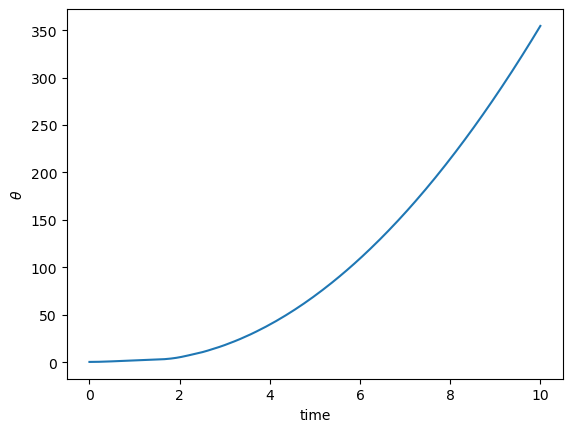

In [25]:
torque = .9

sol = solve_ivp(lambda t, y: pendulum(t, y, L, torque), 
                [0,10], [theta, dtheta_dt], 
                t_eval = time, 
                rtol=1e-8, atol = 1e-8)
plt.figure(1)
plt.clf()
plt.plot(sol.t, sol.y[0,:])
plt.ylabel('$\\theta$')
plt.xlabel('time')

## Plot the phase space and a solution in phase-space

(-3.141592653589793, 3.141592653589793, -3.141592653589793, 3.141592653589793)

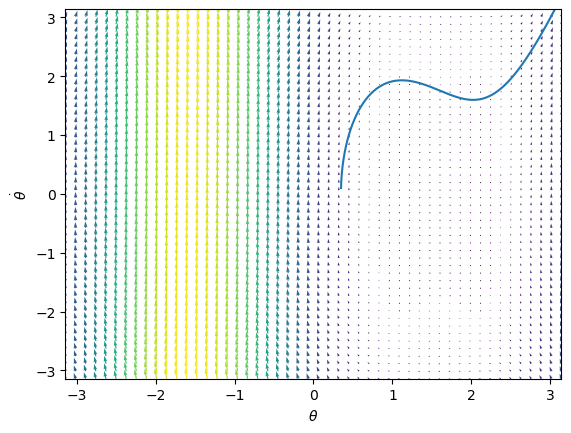

In [26]:
numpoints = 50
rng = np.pi

[x1_vf, x2_vf] = np.meshgrid(np.linspace(-rng,rng,numpoints), 
                             np.linspace(-rng,rng,numpoints)) 

torque = .9
dynamics = pendulum(0, [x1_vf, x2_vf], L, torque)
norm = dynamics[0]**2 + dynamics[1]**2

plt.figure(2)
plt.clf()
plt.quiver(x1_vf, x2_vf, dynamics[0], dynamics[1], norm)

plt.plot(sol.y[0,:], sol.y[1,:])

plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot{\theta}$')
plt.axis([-rng, rng, -rng, rng])


## Plot a bunch of solutions

In [31]:
theta = np.linspace(-10, 10, 5)
dtheta_dt = np.linspace(-6.5, 6.5, 10)
[theta_start, dtheta_start] = np.meshgrid(theta, 
                                          dtheta_dt) 

#### Plot vector field
plt.figure(1)
plt.clf()

numpoints = 50
rng = 3*np.pi

[x1_vf, x2_vf] = np.meshgrid(np.linspace(-rng,rng,numpoints), 
                             np.linspace(-rng,rng,numpoints)) 

dynamics = pendulum(0, [x1_vf, x2_vf], L)
norm = dynamics[0]**2 + dynamics[1]**2
plt.quiver(x1_vf, x2_vf, dynamics[0], dynamics[1], norm)


for init in zip(theta_start.reshape(1,50)[0], dtheta_start.reshape(1,50)[0]):
    # print(init)
    sol = solve_ivp(lambda t, y: pendulum(t, y, L), 
                    [0,10], init, 
                    t_eval = time, 
                    rtol=1e-8, atol = 1e-8)
    plt.plot(sol.y[0,:], sol.y[1,:])

plt.axis([-10, 10, -7.5, 7.5])    

TypeError: pendulum() missing 1 required positional argument: 'torque'

<Figure size 640x480 with 0 Axes>

# Simulating the Van der Pol system

In [28]:
# General inverted pendulum simulator
def vdp(t, state, epsilon):
    x, v = state
    dydt = [v, -x + epsilon*(1 - x**2)*v]
    return dydt

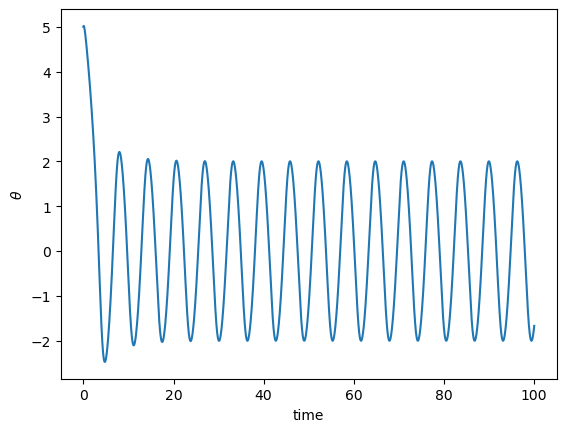

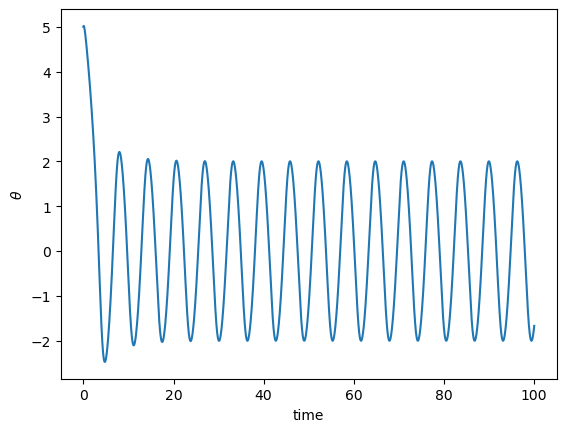

In [29]:
# System constants
epsilon = .2

# Initial condition
x_0 = 5
v_0 = 0.51

dt = 0.001
t_end = 100
time = np.linspace(0,t_end,int(t_end/dt))

sol = solve_ivp(lambda t, y: vdp(t, y, epsilon), 
                [0,t_end], [x_0, v_0], 
                t_eval = time, 
                rtol=1e-8, atol = 1e-8)
plt.figure(1)
plt.clf()
plt.plot(sol.t, sol.y[0,:])
plt.ylabel('$\\theta$')
plt.xlabel('time')
plt.gcf()

(-5.0, 5.0, -5.0, 5.0)

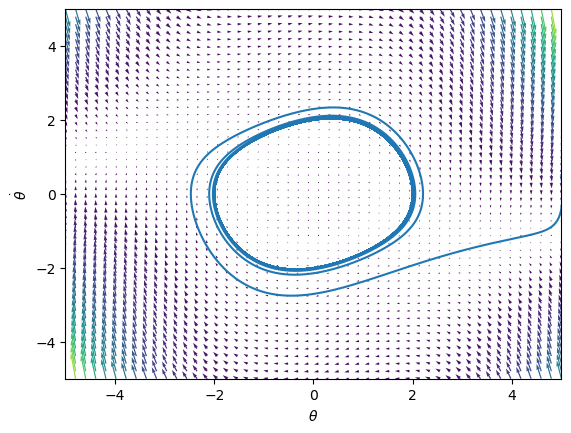

In [30]:
numpoints = 50
rng = 5

[x1_vf, x2_vf] = np.meshgrid(np.linspace(-rng,rng,numpoints), 
                             np.linspace(-rng,rng,numpoints)) 

dynamics = vdp(0, [x1_vf, x2_vf], epsilon)
norm = dynamics[0]**2 + dynamics[1]**2

plt.figure(2)
plt.clf()
plt.quiver(x1_vf, x2_vf, dynamics[0], dynamics[1], norm)

plt.plot(sol.y[0,:], sol.y[1,:])

plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot{\theta}$')
plt.axis([-rng, rng, -rng, rng])
